# Numerical Simulation Laboratory

# Numerical exercise 8

## Exercise 08.1 - 08.2

Sviluppare un codice *Monte Carlo variazionale* per trovare energia autofunzione di ground state di un sistema a singola particella che si muove sotto l'azione del potenziale seguente:
    $$ V(x) = x^4 - \frac{5}{2}x^2 \,. $$
Autovalore e autofunzione sono ricavati utilizzando un variational Monte Carlo code a partire dalla funzione di prova simmetrica e analitica qui di seguito (sebbene questa soluzione analitica sia un'approssimazione per questo problema), che viene inserita nell'equazione di Shrodinger.
    $$ \Psi_T^{\sigma,\mu}(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}} \,.$$

Si tratta quindi di trovare i parametri $\mu$ e $\sigma$ che minimizzano l'autovalore più basso che risolve l'equazione.
Tale autovalore può essere valutato in generale tramite integrazione Monte Carlo del seguente valor medio:
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}  \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}=
\int dx p_{jnt}  E_{loc} \,.
$$

dove le funzioni probabilità congiunta e energia locale sono definite come:
$$ E_{loc} =  \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} \,,$$

$$ p_{jnt} =  \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \,,$$

Riesco quindi a campionare i punti dell'integranda tramite **l'algoritmo di Metropolis**, e utilizzando poi il **data blocking** stimo valor medio e incertezze statistiche dell'integrale. Inoltre è possibile plottare la funzione $|\Psi_T(x)|^2$ facendo un istogramma con i punti sulle ascisse esplorati dall'algoritmo.

### <font color=red> Variational Monte Carlo e Simulated annealing </font>
Poichè lo stato fondamentale è caratterizzato dal minimo dell'energia del sistema, i parametri variazionali $\mu$ e $\sigma$ che corrispondono al ground state devono minimizzare l'integrale dell'Hamiltoniana $\langle {\hat H} \rangle_T$. Per ottimizare tali parametri è stato utilizzato il metodo del **simulated annealing**.
Utilizzo l'algoritmo di Metropolis con transizione uniforme di ampiezza $\delta=0.75$ per campionare posizioni successive nello spazio dei parametri variazionali $\mu$ e $\sigma$ e accetto ogni mossa con una probabilità pari a:

$$ \alpha = min \left[1, \exp^{-\beta\left( \Delta E \right)}  \right] \quad \quad 
    \Delta E = \langle {\hat H} \rangle_{\mu', \sigma'} -  \langle {\hat H} \rangle_{\mu, \sigma}    \,,$$
    
in cui $\left( \mu', \sigma' \right)$ corrisponde alla posizione proposta, $\left(\mu, \sigma \right)$ è la posizione attuale e il parametro $\beta$ rappresenta l'inverso di una **temperatura fittizia** $t=\frac{1}{\beta}$ che durante il procedimento tende gradualmente a zero simulando il raffreddamento di un sistema termodinamico (**annealing process**). In particolare durante il procedimento di minimizzazione ho fatto variare la temperatura dal valore massimo $t_{max}=10$ fino al valore minimo $t_{min}=0.1$: in questo modo l'algoritmo campiona valori che si avvicinano progressivamente al minimo globale dell'energia $\langle {\hat H} \rangle_{\mu, \sigma}$; quindi man mano che abbasso la temperatura l'acceptance rate del simulated annealing tende a ridursi. Per ogni coppia di parametri variazionali ho calcolato l'integrale Monte Carlo utilizzando $50$ blocchi da $2000$ step ciascuno e per ogni valore di $T$ ho campionato $100$ valori per i parametri $\mu$ e $\sigma$ da ottimizzare.

Ho così ottenuto i seguenti **parametri ottimali**:
    $$ \mu=0.799 \,, \quad \sigma=0.638 \,.$$

L'andamento dell'energia di ground state ottenuta poi dalla simualzione con questi parametri (di nuovo 50 blocchi da 2000 step, con $\delta$ aggiustato in modo da avere *acceptance rate* di circa $50\%$) è mostrata di seguito e posso confrontarlo con l'energia ottenuta attraverso il *central differences method* implementato qui di seguito.

Tra i due risultati c'è uno scarto piuttosto accettabile del $4\%$, ma non buona compatibilità per quanto riguarda la convergenza del risultato, visto che i due valori finali distano qualche deviazione standard tra loro

Ground state energy with CD method:  -0.4605
Ground state energy with VMC method: -0.4415
Scarto relativo:  4.21 %


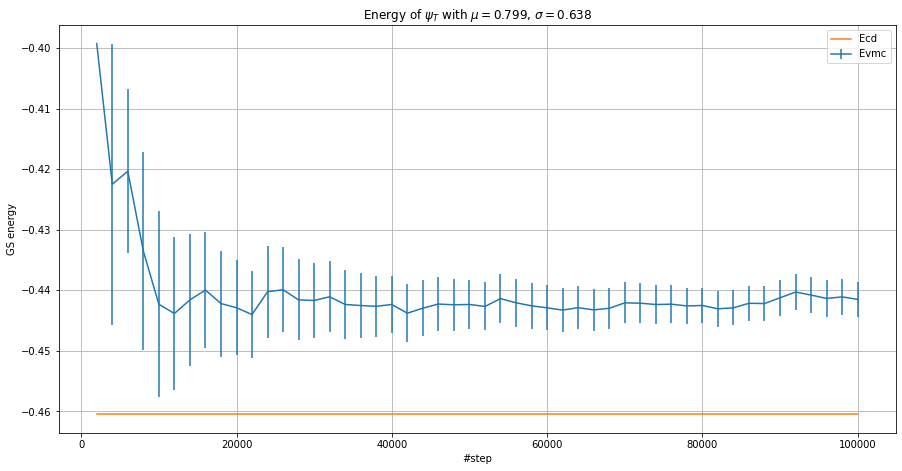

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
pi = np.pi

def Vpot(x):
    return (x**2 - 2.5)*x**2

a = 10
N = 1000 # number of iterations
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# Hamiltonian matrix
H = (-CDiff)/(2*dx**2) + np.diag(V)
# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)
# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

#Autovalori energia
print("Ground state energy with CD method: ", round(E[0],4) )

fig=plt.figure(figsize=(15,7.5))
M,Evmc,errEvmc = np.loadtxt('data/Hmin.dat', unpack=True)
print("Ground state energy with VMC method:", round(Evmc[-1], 4))
print("Scarto relativo: ", round( abs((Evmc[-1]-E[0])/(Evmc[-1]+E[0])) *2 *100, 2), '%')

plt.title("Energy of $\psi _T$ with $\mu=0.799$, $\sigma=0.638$")
plt.errorbar(M, Evmc, yerr=errEvmc, label='Evmc')
plt.plot(M, E[0]* M**0, label='Ecd')
plt.xlabel("#step")
plt.ylabel("GS energy")
plt.legend()
plt.grid(True)
plt.show()

### <font color=blue> Probability density function $|\psi_{GS}|^2$ </font>
Il grafico sottostante mostra: 
- in <font color=blue> blu </font> una densità di probabilità teorica, cioè calcolata a partire da valori teorici dei parametri $\mu$ e $\sigma$

- in <font color=green> verde </font> la densità di probabilità ottenuta dal *central differences method*, cioè il modulo quadro del primo autovettore della matrice a differenze finite.

- in <font color=orange> arancio </font> la densità di probabilità campionata tramite l'algoritmo di **Metropolis** per la funzione d'onda ottimizzata. Essa, come detto in precedenza, è stata costruita come istogramma dei valori di ascissa campionati. L'istogramma è costruito nell'intervallo $(-\mu -3\sigma, \mu +3\sigma)$ in $200$ bins.

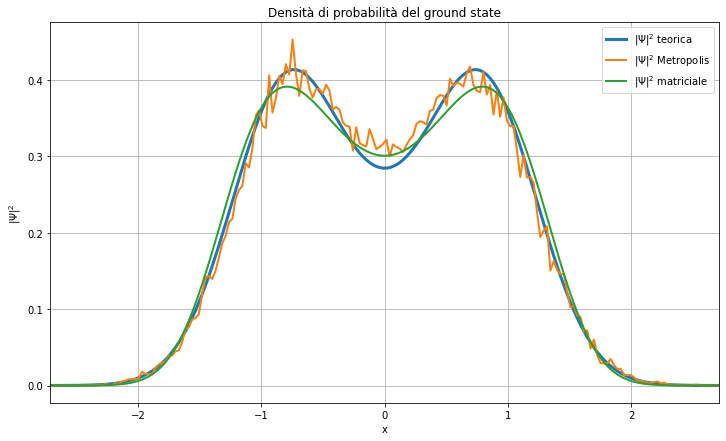

In [12]:
X, Psi2 = np.loadtxt('data/psiopt.out', unpack=True)
muvmc=X[-1]
sigmavmc=Psi2[-1]
X=np.delete(X, -1)
Psi2=np.delete(Psi2, -1)

muteor = 0.8070
sigmateor= 0.6221
Psiteo = np.exp( -(X-muteor)**2/(2*sigmateor*sigmateor) ) + np.exp( -(X+muteor)**2/(2*sigmateor*sigmateor) )
pdf = Psiteo**2
pdf /= integrate.simps(pdf, X) #normalizzo

plt.figure(figsize=(12,7))
plt.plot(X, pdf, label='$|\Psi|^2$ teorica', lw=3)
plt.plot(X, Psi2, label='$|\Psi|^2$ Metropolis', lw=2)
plt.plot(x,(psi[0])**2, label="$|\Psi|^2$ matriciale", lw=2)
plt.xlim(-muvmc-3*sigmavmc, muvmc+3*sigmavmc) 
plt.title('Densità di probabilità del ground state')
plt.xlabel("x")
plt.ylabel("$|\Psi|^2$")
plt.grid(True)
plt.legend()
plt.show()

## Exercise 08.3
Applicare gli algoritmi *Path Integral Ground State* e *Path Integral Monte Carlo* allo stesso sistema monodimensionale per confrontare i risultati.

### <font color='blue'> Path Integral Ground State </font>
I seguenti grafici riportano i risultati ottenuti per l'energia cinetica, l'energia potenziale e per la distribuzione di probabilità applicando il codice *PIGS* al sistema con una funzione d'onda costante $\Psi(x) = 1$.  I grafici mostrano l'andamento dell'energia ottenuta con un tempo immaginario di propagazione $t=8.0$ in funzione dei $300$ timeslices utilizzati e la densità di probabilità confrontata con quella ottenuta tramite l'algoritmo di Metropolis nel precedente calcolo variazionale.

Energia cinetica media: 0.3253
Energia potenziale media: -0.7753
Energia totale ground-state: -0.45


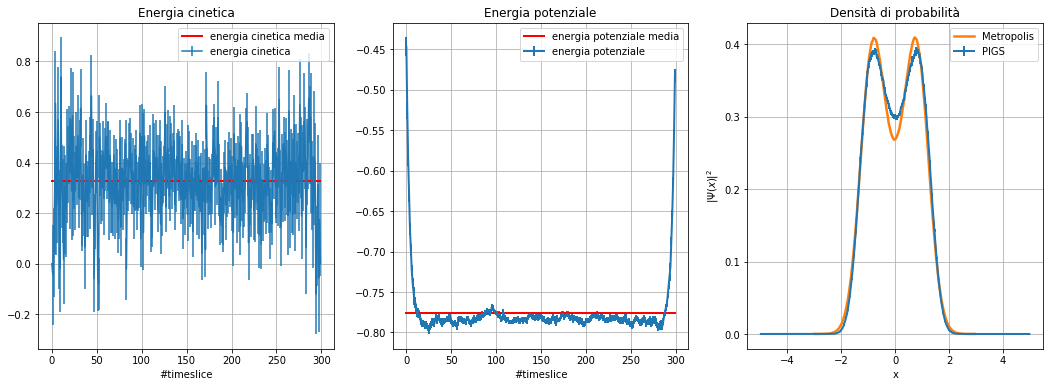

In [134]:
#funzione d'onda costante
t, E1, errE1 = np.loadtxt('Files/PIGS/Cost_kinetic.dat', unpack=True)
t, V1, errV1 = np.loadtxt('Files/PIGS/Cost_potential.dat', unpack=True)
x, psiCost, errCost = np.loadtxt('Files/PIGS/Cost_probability.dat', unpack=True)

meanE1 = np.mean(E1)*t**0
meanV1 = np.mean(V1)*t**0

print("Energia cinetica media:", round(meanE1[0],4))
print("Energia potenziale media:", round(meanV1[0],4))
print("Energia totale ground-state:", round(meanE1[0]+meanV1[0],4))

fig=plt.figure(figsize=(18,6))
plt.subplot(131) #energia cinetica Psi_cost
plt.plot(t, meanE1, c='red', lw=2, label='energia cinetica media')
plt.errorbar(t, E1, yerr=errE1, label='energia cinetica')
plt.title("Energia cinetica")
plt.xlabel("#timeslices")
plt.legend()
plt.grid(True)

plt.subplot(132) #energia potenziale Psi_cost
plt.plot(t, meanV1, c='red', lw=2, label='energia potenziale media')
plt.errorbar(t, V1, yerr=errV1, label='energia potenziale', lw=2)
plt.title("Energia potenziale")
plt.xlabel("#timeslices")
plt.legend()
plt.grid(True)
         
plt.subplot(133) #probabilità Psi_cost
plt.errorbar(x, psiCost, yerr=errCost, label='PIGS', lw=2)
plt.plot(X, Psi2, label='Metropolis', lw=2.5)
plt.title("Densità di probabilità")
plt.xlabel("x")
plt.ylabel("|$\Psi(x)|^2$")
plt.legend()
plt.grid(True)
plt.show()

I seguenti grafici riportano i risultati ottenuti per l'energia cinetica, l'energia potenziale e per la distribuzione di probabilità applicando il codice *PIGS* al sistema utilizzando la funzione d'onda 
    $$ \Psi_T^{\sigma,\mu}(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}} \,,$$
dove $\mu=0.83$ e $\sigma=0.63$ sono i parametri variazionali ottimizzati. I grafici mostrano l'andamento dell'energia ottenuta con un tempo immaginario di propagazione $t=8.0$ in funzione dei $300$ timeslices utilizzati e la densità di probabilità confrontata con quella ottenuta tramite l'algoritmo di Metropolis nel precedente calcolo variazionale.

Energia cinetica media: 0.3321
Energia potenziale media: -0.7812
Energia totale ground-state: -0.4492


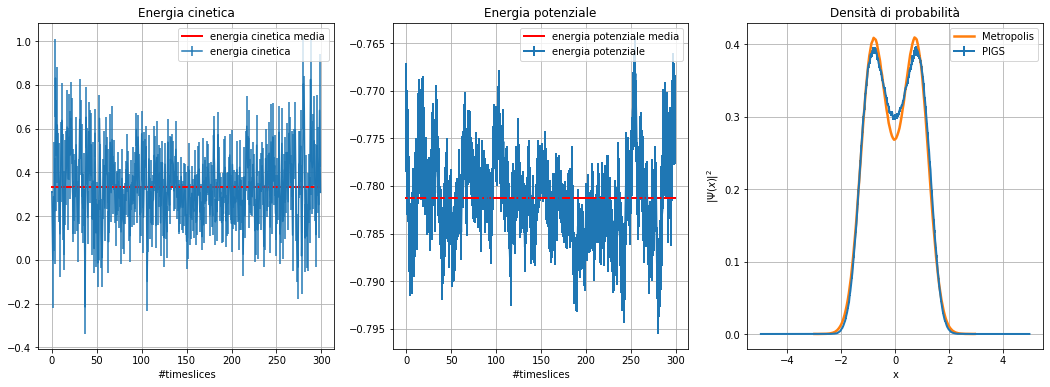

In [3]:
#funzione d'onda Psi_trial
t, E2, errE2 = np.loadtxt('Files/PIGS/Trial_kinetic.dat', unpack=True)
t, V2, errV2 = np.loadtxt('Files/PIGS/Trial_potential.dat', unpack=True)
x, psiTrial, errTrial = np.loadtxt('Files/PIGS/Trial_probability.dat', unpack=True)

meanE2 = np.mean(E2)*t**0
meanV2 = np.mean(V2)*t**0

print("Energia cinetica media:", round(meanE2[0],4))
print("Energia potenziale media:", round(meanV2[0],4))
print("Energia totale ground-state:", round(meanE2[0]+meanV2[0],4))

fig=plt.figure(figsize=(18,6))
plt.subplot(131) #energia cinetica Psi_trial
plt.errorbar(t, E2, yerr=errE2, label='energia cinetica')
plt.plot(t, meanE2, c='red', lw=2, label='energia cinetica media')
plt.title("Energia cinetica")
plt.xlabel("#timeslices")
plt.legend()
plt.grid(True)

plt.subplot(132) #energia potenziale Psi_trial
plt.plot(t, meanV2, c='red', lw=2, label='energia potenziale media')
plt.errorbar(t, V2, yerr=errV2, label='energia potenziale', lw=2)
plt.title("Energia potenziale")
plt.xlabel("#timeslices")
plt.legend()
plt.grid(True)
         
plt.subplot(133) #probabilità Psi_trial
plt.errorbar(x, psiTrial, yerr=errTrial, label='PIGS', lw=2)
plt.plot(X, Psi2, label='Metropolis', lw=2.5)
plt.title("Densità di probabilità")
plt.xlabel("x")
plt.ylabel("|$\Psi(x)|^2$")
plt.legend()
plt.grid(True)
plt.show()

Il seguente grafico mostra il comportamento dell'energia potenziale del sistema riducendo progressivamente il tempo immaginario di propagazione: diminuendo tale valore, l'energia potenziale del sistema si discosta dal valore medio ottenuto inizialmente e l'andamento cambia in modo signficativo.
Si può osservare che utilizzando la funzione d'onda $\Psi_T^{\mu, \sigma}$ rispetto alla funzione costante $\Psi = 1$, il tempo immaginario di propagazione può essere ridotto ad un valore inferiore di oltre un ordine di grandezza in quanto le variazioni introdotte sono estremamente minori.

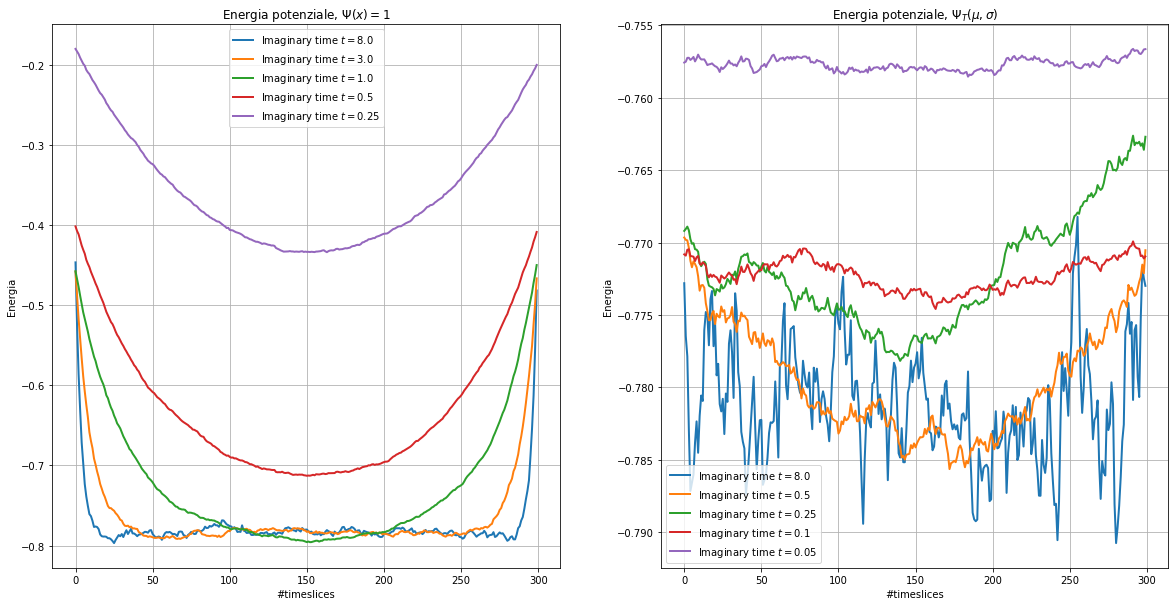

In [204]:
imagT = [8.0, 3.0, 1.0, 0.5, 0.25]
fig=plt.figure(figsize=(20, 10))

plt.subplot(121) #funzione d'onda costante
for i in range(len(imagT)):
    lab = 'Imaginary time $t=' + str(imagT[i]) + '$'
    t, V, err = np.loadtxt('Files/PIGS/imagTimeCost/potential_' + str(imagT[i]) + '.dat', unpack=True)
    plt.plot(t, V,  label=lab, lw=2)
    
plt.title("Energia potenziale, $\Psi(x)=1$")
plt.xlabel("#timeslices")
plt.ylabel("Energia")
plt.legend(loc='best')
plt.grid(True)

imagT = [8.0, 0.5, 0.25, 0.1, 0.05]
plt.subplot(122) #funzione d'onda trial
for i in range(len(imagT)):
    lab = 'Imaginary time $t=' + str(imagT[i]) + '$'
    t, V, err = np.loadtxt('Files/PIGS/imagTimeTrial/potential_' + str(imagT[i]) + '.dat', unpack=True)
    plt.plot(t, V,  label=lab, lw=2)
    
plt.title("Energia potenziale, $\Psi_T(\mu, \sigma)$")
plt.xlabel("#timeslices")
plt.ylabel("Energia")
plt.legend(loc='best')
plt.grid(True)

plt.show()

### <font color='blue'> Path Integral Monte Carlo </font>
Il seguente grafico, ottenuto utilizzando il codice *PIMC*, mostra come viene modificata la distribuzione di probabilità aumentando la temperatura del sistema.

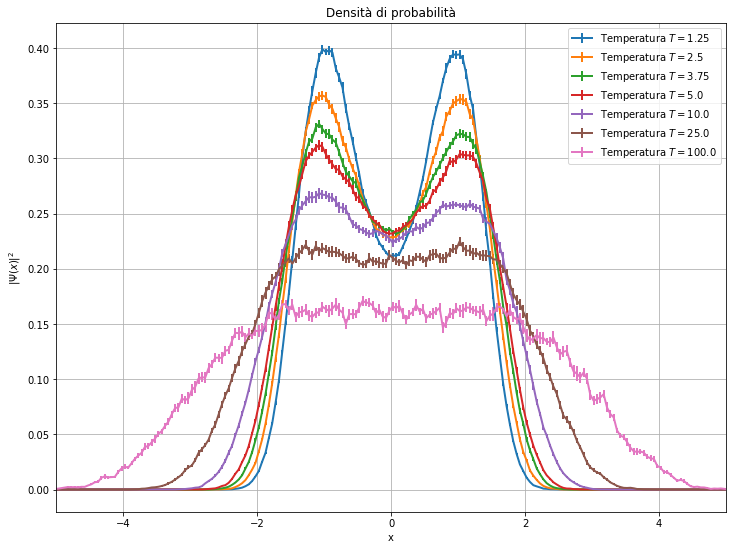

In [133]:
T = [1.25, 2.5, 3.75, 5.0, 10.0, 25.0, 100.0]
fig=plt.figure(figsize=(12,9))

for i in range(len(T)):
    lab = 'Temperatura $T=' + str(T[i]) + '$'
    #probabilità in funzione della temperatura
    x, psi, err = np.loadtxt('Files/PIMC/probability_' + str(T[i]) + '.dat', unpack=True)
    plt.errorbar(x, psi, yerr=err, label=lab, lw=2)
    
plt.title("Densità di probabilità")
plt.xlim(-5,5)
plt.xlabel("x")
plt.ylabel("$|\Psi(x)|^2$")
plt.legend()
plt.grid(True)
plt.show()